# Fundamentos de Ciência de Dados

Work made by:
- João António, nº 76558, joaoantonio@ua.pt, Mestrado em ciência de dados (9306)
- Tiago Freitas, nº 76748, tiagofreitas79@ua.pt, Mestrado em ciência de dados (9306)

## Organizações não governamentais de ambiente por 100 000 habitantes (N.º) por Localização geográfica (NUTS - 2013); Anual
https://www.ine.pt/xportal/xmain?xpid=INE&xpgid=ine_indicadores&indOcorrCod=0008290&contexto=bd&selTab=tab2

### Base de dados: Nuts 2013

### Sinais convencionais
Sinais convencionais por ausência de valor
- `…`	Dado confidencial
- `-`	Dado nulo ou não aplicável
- `x`	Dado não disponível
- `o`	Dado inferior a metade do módulo da unidade utilizada
- `∞`	Infinito

Sinais convencionais adicionais ao valor
- `//` Dado preliminar
- `&`	Dado provisório
- `»`	Dado previsto
- `*`	Dado rectificado
- `§`	Desvio do padrão de qualidade/Coeficiente de variação elevado
- `“`	Estimativa
- `“E` Dado estimado pelo Eurostat
- `┴`	Quebra de série/comparabilidade
- `i`	Mais informação em anexo

## Sinais convencionais diversos
- `µ`	Média
- `=`	Igual
- `>`	Maior que
- `≥`	Maior ou igual
- `<`	Menor que
- `≤`	Menor ou igual
- `%`	Percentagem
- `‰`	Permilagem
- `∑`	Soma de
- `≠`	Diferente

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
%matplotlib inline

## Load INE Culturas

In [105]:
file_csv = "./data_FCD/ine_principais_culturas_agricolas.csv"

In [106]:
def load_ine_cultures(file_csv):
    df=pd.read_csv(file_csv,delimiter=";", encoding="latin-1", header=[4, 6], nrows=12, on_bad_lines="skip")    

    ## Drop Columns
    df.drop(labels=[0], inplace=True) # Drop first row
    df.drop(columns=df.columns[-1], inplace=True) # Drop last column
    
    df.drop(labels=[9,11], inplace=True) # Drop repeated Açores and Madeira rows
    
    ## Reset of the Index as Region with just the region codes
    df['Region_split'] = df[df.columns[0]].apply(lambda x : str(x).rsplit(sep = ':', maxsplit=1))
    df['Region']= df['Region_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
    df['Region_names']= df['Region_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
    region_names = df["Region_names"].to_list()
    df.set_index("Region", inplace=True)
    columns_to_rem = [0, -1, -2] # Remove Unnamed: 0_level_1(1st), Region_split(last) and Region_names(before last) columns
    df.drop(df.columns[columns_to_rem], axis=1, inplace=True)
    
    ## Changed regions names to just one word per region to make it easier for graphical representations later
    for k_ind, k in enumerate(region_names):
        k_split = k.split(" ")
        if len(k_split) > 1:
            region_names[k_ind] = k_split[-1]
    
    ## Redo the Headers, from unnamed to the year
    c0 = df.columns.get_level_values(0).to_series()
    c1 = list(df.columns.get_level_values(1).to_series())
    c0 = c0.mask(lambda c: c.str.startswith("Unnamed")).ffill()
    df.columns = [c0, c1]
    
    ## Bringing the year to the index
    df = df.stack(level=0)
    df.index.names=['Region', 'Year']
    
    ## Replacing 'x', 'x x', '- -' for their respective value
    df.replace({'x':np.nan,'x x':np.nan,'- -':0,'nan':np.nan},inplace=True)
    
    ## Replacing provisional data 
    for column in df:
        df[column]=df[column].map(lambda x: str(x).rstrip(' &'))
        df[column]=df[column].map(lambda x: str(x).rstrip(' *'))
        
    # This method turns data to stringd so we have to turn the data back to numeric
    for column in df:
        df[column]=pd.to_numeric(df[column],'coerce')
    
    return df, region_names

In [107]:
data, region_names = load_ine_cultures(file_csv)
data

Abacate  Abóbora (inclui butternut)  Alface  Alho  Alho-porro  \
Region Year                                                                  
PT     1986      NaN                         NaN     NaN   NaN         NaN   
       1987      NaN                         NaN     NaN   NaN         NaN   
       1988      NaN                         NaN     NaN   NaN         NaN   
       1989      NaN                         NaN     NaN   NaN         NaN   
       1990      NaN                         NaN     NaN   NaN         NaN   
...              ...                         ...     ...   ...         ...   
3      2017      NaN                         NaN     NaN   NaN         NaN   
       2018      0.0                         NaN     NaN   NaN         NaN   
       2019   8243.0                         NaN     NaN   NaN         NaN   
       2020   9164.0                         NaN     NaN   NaN         NaN   
       2021   9726.0                         NaN     NaN   NaN         NaN   

             Ameixa  Amoras  Amêndoa  Ananás  Arroz  ...  Trigo  Trigo duro  \
Region Year                                          ...                      
PT     1986    6006     NaN      848     NaN   4463  ...   1630        1250   
       1987    6266     NaN      996     NaN   4322  ...   1694        1355   
       1988    5173     NaN      506     NaN   4266  ...   1380         789   
       1989    5769     NaN     1237     NaN   4290  ...   1915        1197   
       1990    6436     NaN     1098     NaN   4614  ...   1429        1270   
...             ...     ...      ...     ...    ...  ...    ...         ...   
3      2017    7529     NaN        0     0.0      0  ...   1986           0   
       2018    7760     0.0        0     0.0      0  ...   1986           0   
       2019    8339     0.0        0     0.0      0  ...   2002           0   
       2020    5880     0.0        0     0.0      0  ...   1988           0   
       2021    5018     0.0        0     0.0      0  ...   2002           0   

             Trigo mole  Triticale  Uva de mesa  Uva para vinho  \
Region Year                                                       
PT     1986        1669       1405         6720            4122   
       1987        1727       1410         7702            5765   
       1988        1425       1237         3179            1965   
       1989        1977       1666         5517            3963   
       1990        1445       1244         5740            5806   
...                 ...        ...          ...             ...   
3      2017        1986          0         7881            5490   
       2018        1986          0         7881            4386   
       2019        2002          0         7881            6224   
       2020        1988          0         7883            5980   
       2021        2002          0         7883            6474   

             Uva para vinho (DOP)  Uva para vinho (IGP)  \
Region Year                                               
PT     1986                   NaN                   NaN   
       1987                   NaN                   NaN   
       1988                   NaN                   NaN   
       1989                   NaN                   NaN   
       1990                   NaN                   NaN   
...                           ...                   ...   
3      2017                   NaN                   NaN   
       2018                   NaN                   NaN   
       2019                   NaN                   NaN   
       2020                   NaN                   NaN   
       2021                   NaN                   NaN   

             Uva para vinho (Vinhos sem certificação)  Vinha  
Region Year                                                   
PT     1986                                       NaN   4199  
       1987                                       NaN   5824  
       1988                                       NaN   2002  
       1989    

## Production by Region for the Year 2020

<Figure size 1152x576 with 0 Axes>

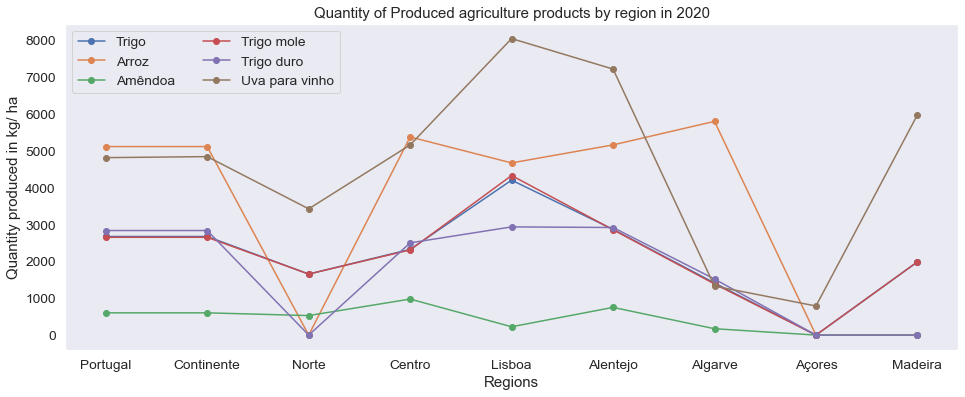

In [108]:
plt.figure(figsize=(16, 8))
df_2020=data.xs("2020", level=1)

df_2020.columns
## Obtain index of Specific Products draw those index on plot
labels_to_plot = ["Trigo", "Arroz", "Amêndoa", "Trigo mole", "Trigo duro", "Uva para vinho"]
index_to_plot = [list(df_2020.columns).index(product) for product in labels_to_plot]

# filter_col = ["Trigo", "Trigo duro", "Ananás", "Amêndoa",]
df_2020[df_2020.columns[index_to_plot]].plot(figsize=(16, 6), marker="o")
plt.title("Quantity of Produced agriculture products by region in 2020")
plt.xlabel("Regions")
plt.ylabel("Quantity produced in kg/ ha")
plt.legend(loc="upper left", ncol=2)
plt.grid()
plt.xticks(range(len(region_names)), region_names)
plt.show()
# plt.savefig("Production_2020.png")

## IPMA Notebooks
Note that the Structure of pages inside the Excel is given by:
- Shet 0 is metadata
- Shet 1 is tmin
- Shet 2 is tmax
- Shet 3 is Pluviosity

In [109]:
# Global Functions have the name in full capslock to respect pep8
# 1st Code is of the region, the second is the name of the IPMA
MAP_REGIONS_EXCEL = {
    "Norte": [11, 11],
    "Centro": [16, 132],
    "Lisboa": [17, 320],
    "Alentejo": [18, 571],
    "Algarve": [15, 554],
    "Açores": [2, 360],
    "Madeira": [3, 522],
}
IPMA_COLUMNS = ["Tmin", "Tmax", "Prec", "TmaxA", "TminA", "Prec_max", "Prec_min"]

In [110]:
def add_extra_col(meteo_coln, sheet_number):
    sheet_number += 1  # So that 1 is the Tmin, 2 is the Tmax and 3 is the precipitation
    index_describe = 1  # Mean

    if meteo_coln == "TmaxA":
        # Meaning T Max Ablsolute, so the real maximum temperature that we obtained that year
        index_describe = 7  # Max
        sheet_number = 2  # Tmax

    elif meteo_coln == "TminA":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 3  # Min
        sheet_number = 1  # Tmin

    elif meteo_coln == "Prec_min":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 3  # Min
        sheet_number = 3  # Precipitation Sheet

    elif meteo_coln == "Prec_max":
        # Meaning T Min Ablsolute, so the real minimum temperature that we obtained that year
        index_describe = 7  # Max
        sheet_number = 3  # Precipitation Sheet

    for region, codes in MAP_REGIONS_EXCEL.items():
        meteo2 = pd.read_excel(
            f"./data_FCD/IPMA/{codes[1]}-tx-tn-prec.xlsx",
            sheet_name=sheet_number,
        )
        meteo2.dropna(axis=0, how="any", inplace=True)

        #Obtain only years after 1986
        meteo2 = meteo2[meteo2.year > 1986]
        meteo2.set_index("year", inplace=True)
        meteo2.index.names = ["Region"]
        
        # use teh Describe that gives mean (index 2), max (index 7) and min (index 3)
        data_prec = meteo2.transpose().describe()
        index_names_arr = data_prec.index.values
        
        #Rename that column to region and drop the others
        index_names_arr[index_describe] = codes[0]
        for k_name in index_names_arr:
            if k_name != codes[0]:
                data_prec.drop(index=k_name, inplace=True)
        
        years_list = data_prec.keys()
        header = [years_list, [meteo_coln] * len(years_list)]
        data_prec.columns = header
        
        data_f = (
            data_prec
            if region == list(MAP_REGIONS_EXCEL.keys())[0]
            else pd.concat([data_f, data_prec])
        )
    return data_f


In [111]:
def load_ipma():
    ipma = {
        type_data: add_extra_col(type_data, k)
        for k, type_data in enumerate(IPMA_COLUMNS)
    }
    ## Make all the concats at the same time to save time
    meteo = pd.concat([ipma[k] for k in IPMA_COLUMNS], axis=1)
    # meteo["T_range"] = meteo["TmaxA"] - meteo["TminA"]
    meteo= meteo.stack(level=0)
    meteo.index.names = ["Region", "Year"]
    return meteo.reindex(sorted(meteo.columns), axis=1)

In [112]:
meteo = load_ipma()

## Added DTs
meteo['dT']=meteo['Tmax']-meteo['Tmin']
meteo['dTA']=meteo['TmaxA']-meteo['TminA']
meteo

Prec  Prec_max  Prec_min       Tmax      TmaxA       Tmin  \
Region Year                                                                    
11     1987  132.408333     478.1      10.2  14.991667  25.200000   6.300000   
       1988  109.783333     368.5       0.0  14.208333  24.000000   5.875000   
       1989  132.233333     652.1       0.4  15.800000  27.500000   7.016667   
       1990   79.175000     253.7       5.8  15.366667  26.700000   6.583333   
       1991  110.366667     262.1      11.1  14.533333  26.600000   5.741667   
...                 ...       ...       ...        ...        ...        ...   
3      2014   40.133333     111.5       0.0  22.800000  26.807143  17.104762   
       2015   24.958333     135.1       0.0  22.791667  27.000000  17.233333   
       2016   53.925000     163.1       0.0  22.975000  28.000000  17.358333   
       2017   31.416667     104.6       0.0  23.350000  26.800000  17.750000   
       2018   45.908333     163.5       0.0  22.750000  26.600000  17.241667   

                 TminA        dT     dTA  
Region Year                               
11     1987   0.200000  8.691667  25.000  
       1988   0.700000  8.333333  23.300  
       1989   0.300000  8.783333  27.200  
       1990   0.600000  8.783333  26.100  
       1991  -0.600000  8.791667  27.200  
...                ...       ...     ...  
3      2014  13.832143  5.695238  12.975  
       2015  13.300000  5.558333  13.700  
       2016  14.100000  5.616667  13.900  
       2017  14.200000  5.600000  12.600  
       2018  13.500000  5.508333  13.100  

[209 rows x 9 columns]

If you look into this table we can see that Madeira (region 3) has some strange values for temperature, most of Tmin is zero

## Correlation between our columns of Meterologic Data
Here we can see a high correlation between `Prec` and `Prec_max` and between the `Tmax`and `Tmin` and `TminA` we can also see some correlation

In [113]:
meteo

Prec  Prec_max  Prec_min       Tmax      TmaxA       Tmin  \
Region Year                                                                    
11     1987  132.408333     478.1      10.2  14.991667  25.200000   6.300000   
       1988  109.783333     368.5       0.0  14.208333  24.000000   5.875000   
       1989  132.233333     652.1       0.4  15.800000  27.500000   7.016667   
       1990   79.175000     253.7       5.8  15.366667  26.700000   6.583333   
       1991  110.366667     262.1      11.1  14.533333  26.600000   5.741667   
...                 ...       ...       ...        ...        ...        ...   
3      2014   40.133333     111.5       0.0  22.800000  26.807143  17.104762   
       2015   24.958333     135.1       0.0  22.791667  27.000000  17.233333   
       2016   53.925000     163.1       0.0  22.975000  28.000000  17.358333   
       2017   31.416667     104.6       0.0  23.350000  26.800000  17.750000   
       2018   45.908333     163.5       0.0  22.750000  26.600000  17.241667   

                 TminA        dT     dTA  
Region Year                               
11     1987   0.200000  8.691667  25.000  
       1988   0.700000  8.333333  23.300  
       1989   0.300000  8.783333  27.200  
       1990   0.600000  8.783333  26.100  
       1991  -0.600000  8.791667  27.200  
...                ...       ...     ...  
3      2014  13.832143  5.695238  12.975  
       2015  13.300000  5.558333  13.700  
       2016  14.100000  5.616667  13.900  
       2017  14.200000  5.600000  12.600  
       2018  13.500000  5.508333  13.100  

[209 rows x 9 columns]

In [114]:
meteo

Prec  Prec_max  Prec_min       Tmax      TmaxA       Tmin  \
Region Year                                                                    
11     1987  132.408333     478.1      10.2  14.991667  25.200000   6.300000   
       1988  109.783333     368.5       0.0  14.208333  24.000000   5.875000   
       1989  132.233333     652.1       0.4  15.800000  27.500000   7.016667   
       1990   79.175000     253.7       5.8  15.366667  26.700000   6.583333   
       1991  110.366667     262.1      11.1  14.533333  26.600000   5.741667   
...                 ...       ...       ...        ...        ...        ...   
3      2014   40.133333     111.5       0.0  22.800000  26.807143  17.104762   
       2015   24.958333     135.1       0.0  22.791667  27.000000  17.233333   
       2016   53.925000     163.1       0.0  22.975000  28.000000  17.358333   
       2017   31.416667     104.6       0.0  23.350000  26.800000  17.750000   
       2018   45.908333     163.5       0.0  22.750000  26.600000  17.241667   

                 TminA        dT     dTA  
Region Year                               
11     1987   0.200000  8.691667  25.000  
       1988   0.700000  8.333333  23.300  
       1989   0.300000  8.783333  27.200  
       1990   0.600000  8.783333  26.100  
       1991  -0.600000  8.791667  27.200  
...                ...       ...     ...  
3      2014  13.832143  5.695238  12.975  
       2015  13.300000  5.558333  13.700  
       2016  14.100000  5.616667  13.900  
       2017  14.200000  5.600000  12.600  
       2018  13.500000  5.508333  13.100  

[209 rows x 9 columns]

In [115]:
def pairplot_data():
    meteo2 = meteo.reset_index()
    meteo2.set_index("Year")
    return meteo2 

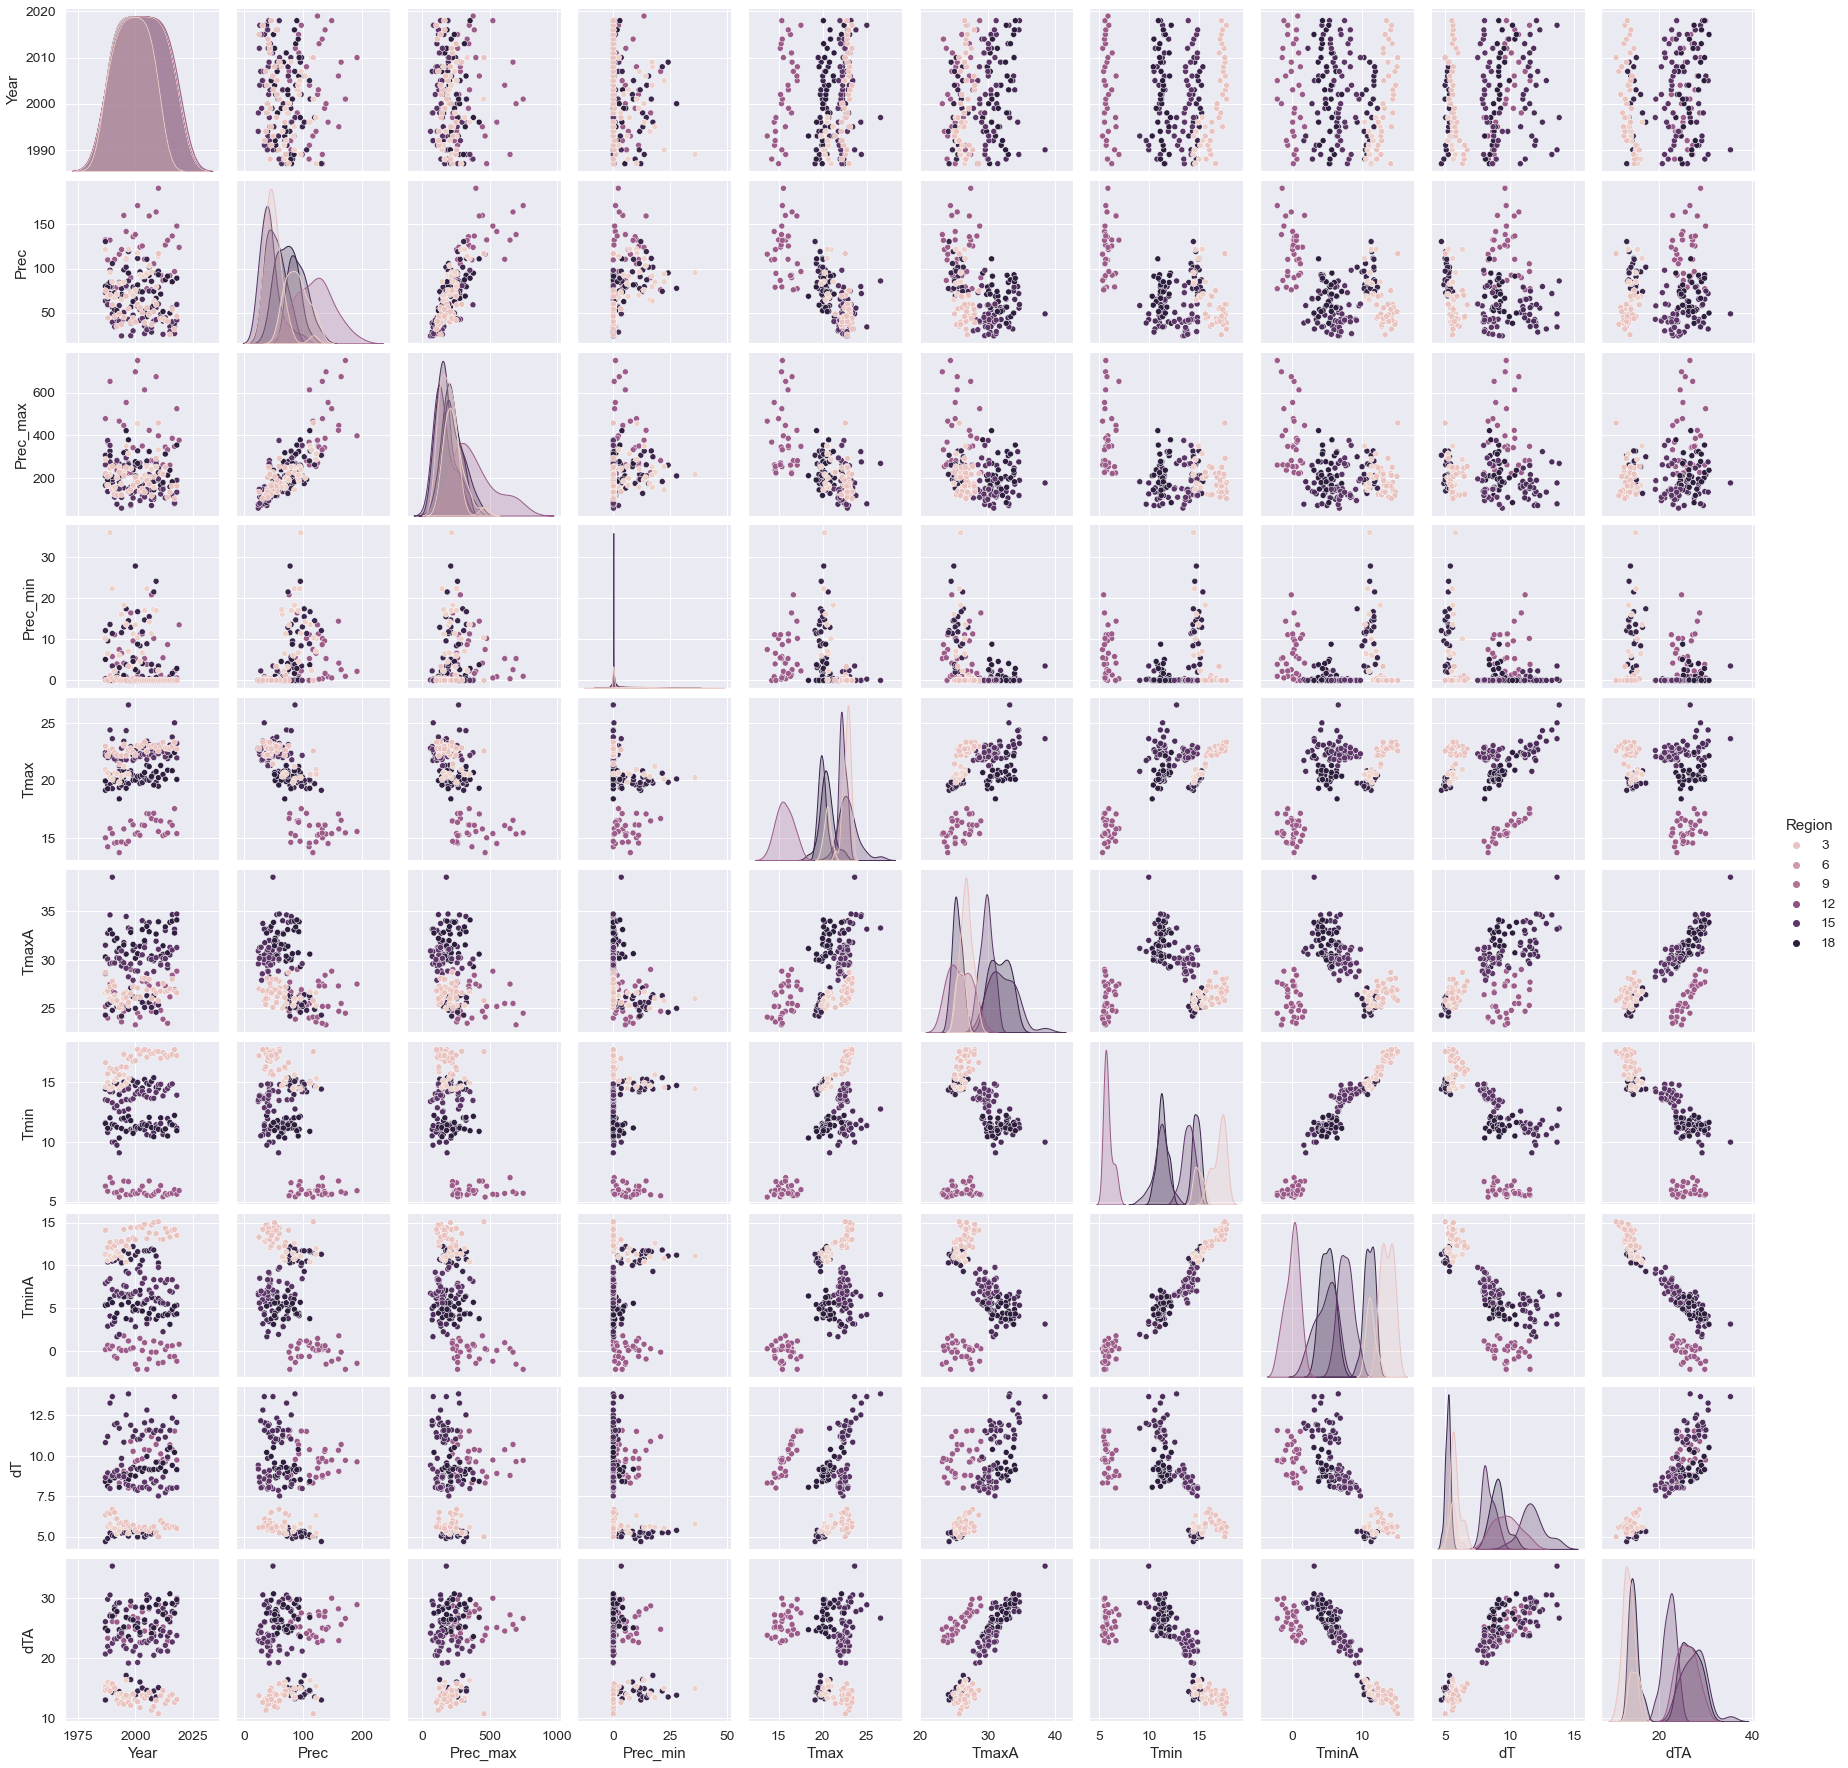

In [116]:
# A pairplot between all the meteo data that we are obtaining
plot_data = pairplot_data()
sns.pairplot(plot_data, hue="Region")
plt.show()

## Production for the 18 region, for 2 selected products

In [117]:
filter_col = ["Trigo", "Amêndoa"]

year = range(1986, 2022)
def create_df_trg_amd(filter_col):
    df_alentejo_trig_amend = {
    }
    for k_col, col in enumerate(filter_col):
        if col not in df_alentejo_trig_amend:
            df_alentejo_trig_amend[col] = []
        for elem in data[col]["18"]:
            df_alentejo_trig_amend[col].append(elem)

    meteo_data = {}
    meteo_region=meteo.xs(18)
    col_to_draw = ["Prec_max"]
    for k_col, col in enumerate(col_to_draw):
        if col not in meteo_data:
            meteo_data[col] = []
        for elem in meteo_region[col]:
            meteo_data[col].append(elem)
        meteo_data["year"] = meteo_region[col].index
        
    for key in df_alentejo_trig_amend:
        df_alentejo_trig_amend[key] = MaxAbsScaler().fit_transform(np.array(df_alentejo_trig_amend[key]).reshape(-1, 1))
    return df_alentejo_trig_amend, meteo_data

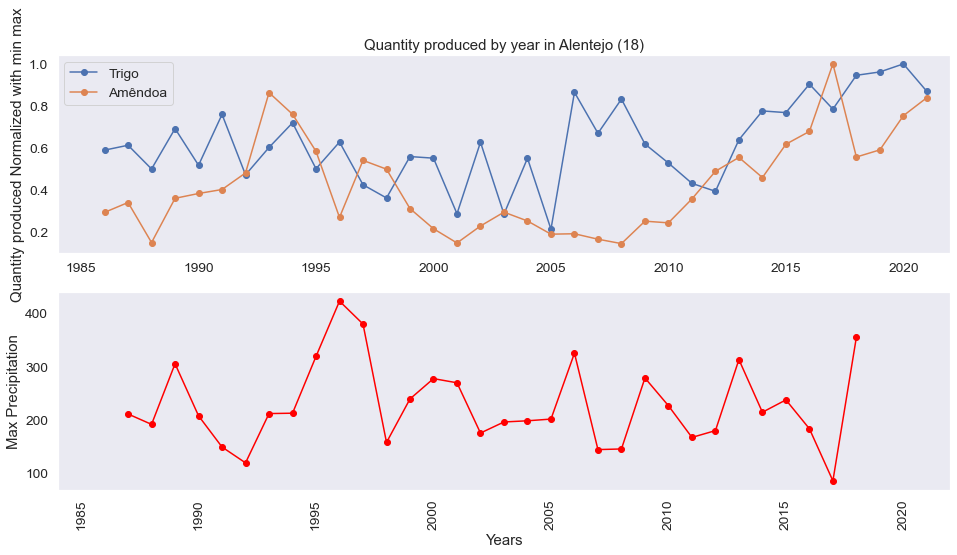

In [118]:
plot_data, plot_data2 = create_df_trg_amd(filter_col)
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
for key in plot_data:
    ax.plot(year, plot_data[key], label=key, marker="o")
ax2.plot(plot_data2["year"], plot_data2["Prec_max"], color="red", marker="o")
ax2.set_xlim([1984, 2022])
ax.set_xlim([1984, 2022])
ax.set_ylabel("Quantity produced Normalized with min max")
ax2.set_ylabel("Max Precipitation")
ax2.grid()
ax.grid()
ax.set_title("Quantity produced by year in Alentejo (18)")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

## Study of the Correlation between the Meteorologic Data and the production of Trigo for the North of Portugal
To do this we have first selected only the years that are common to both datasets, and then we have ploted the correlation

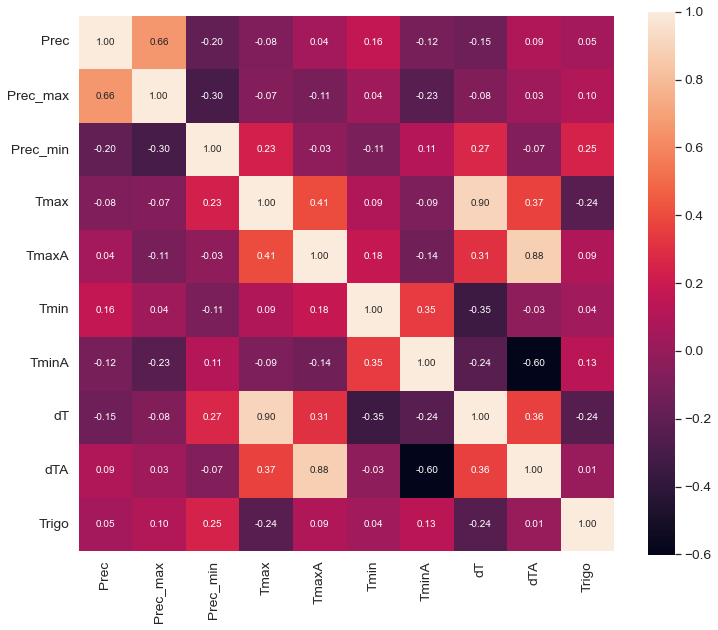

['Prec', 'Prec_max', 'Prec_min', 'Tmax', 'TmaxA', 'Tmin', 'TminA', 'dT', 'dTA', 'Trigo']


In [119]:
meteo_region = meteo.xs(11)
data_region = data.xs("11")
index_to_plot= ["Trigo"]

index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(2019)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index("2019")
data_region = data_region[index_to_plot].iloc[range(index_min,index_max)]


f,ax = plt.subplots(figsize=(12, 10))
cols = list(meteo_region.columns)
cols.append("Trigo")
cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()
print(cols)

## Quantity produced Normalized with min max

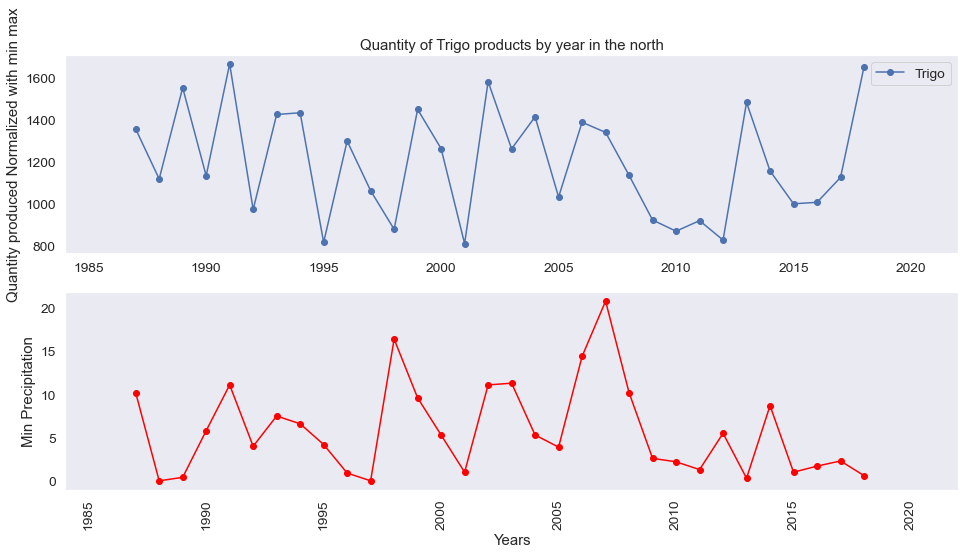

In [120]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(16, 8))
year = range(1987, 2019)
ax.plot(year, data_region.values, label="Trigo", marker="o")
ax2.plot(year, meteo_region["Prec_min"], color="red", marker="o")
ax2.set_xlim([1984, 2022])
ax.set_xlim([1984, 2022])
ax.set_ylabel("Quantity produced Normalized with min max")
ax2.set_ylabel("Min Precipitation")
ax2.grid()
ax.grid()
ax.set_title("Quantity of Trigo products by year in the north")
plt.xlabel("Years")
ax.legend()
plt.xticks(rotation="vertical")
plt.show()

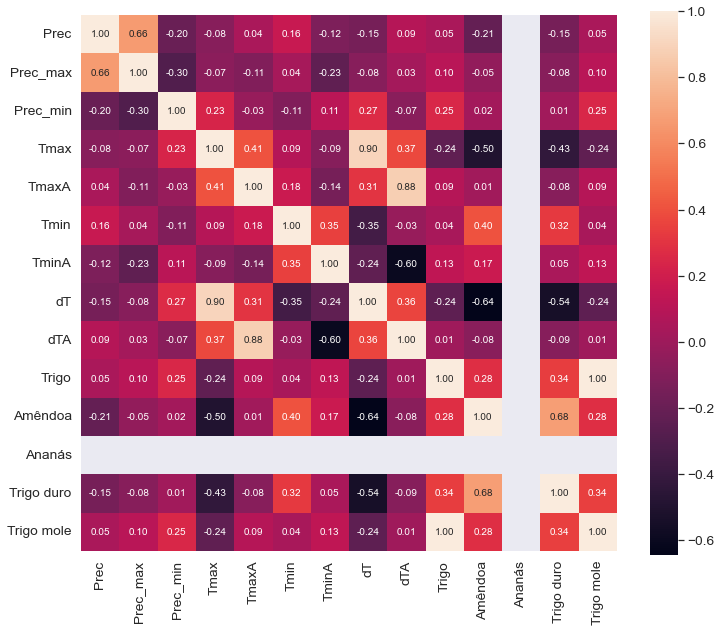

['Prec', 'Prec_max', 'Prec_min', 'Tmax', 'TmaxA', 'Tmin', 'TminA', 'dT', 'dTA', 'Trigo', 'Amêndoa', 'Ananás', 'Trigo duro', 'Trigo mole']


In [121]:
meteo_region = meteo.xs(11)
data_region = data.xs("11")
index_to_plot= ["Trigo", "Amêndoa", "Ananás", "Trigo duro", "Trigo mole"]

index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(2019)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index("2019")
data_region = data_region[index_to_plot].iloc[range(index_min,index_max)]


f,ax = plt.subplots(figsize=(12, 10))
cols = list(meteo_region.columns)
cols += index_to_plot
cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols)
plt.show()
# cols = cols.drop('Transported')
print(cols)

In [122]:
meteo_region.index

Int64Index([1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
            1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
            2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
           dtype='int64', name='Year')

In [123]:
def table_corre(max_year=2010, delta=0, region=None, min_cor=0.7):
    if delta != 0:
        print(f"Correlation values for the products and meteo data, with products with more {delta} years than product")
    if region is None:
        region = [11, 16, 18, 15, 3, 2, 17]
    print(f'{"Region":<10}{"Correlation value":>20} {"Meteo":>20} {"Product":>40}')
    for region_code in region:
        meteo_region = meteo.xs(region_code)
        data_region = data.xs(str(region_code))
        index_min = list(meteo_region.index).index(1987)
        index_max = list(meteo_region.index).index(max_year)
        meteo_region = meteo_region.iloc[range(index_min+delta,index_max+delta)]

        index_min = list(data_region.index).index("1987")
        index_max = list(data_region.index).index(str(max_year))
        data_region = data_region.iloc[range(index_min,index_max)]

        cm = np.corrcoef(meteo_region.values.T, data_region.values.T)
        list_nomes = list(meteo_region.columns)
        list_nomes.extend(data_region.columns)

        for k, sub_cm in enumerate(cm):
            if k <= 9: #Since 9 are the columns of meteo
                for k2, elem2 in enumerate(sub_cm):
                    if abs(elem2) > min_cor and k2 > 9:
                        print(f"{str(region_code)}{' ':>10}{elem2:>20}{list_nomes[k]:>20}{list_nomes[k2]:>40}")

In [124]:
table_corre(delta=0, min_cor=0.75)

Region       Correlation value                Meteo                                  Product
11           -0.8187393856458363                  dT                                   Ginja
11           -0.8345166280250229                  dT                                 Nespera
11           -0.7766259039695558                  dT                                  Tabaco
11           -0.7930971096957863                  dT                                 Toranja
18            0.7583288413307402                  dT                                  Ameixa
18           -0.7657966137960036                  dT                            Grão-de-bico
18            0.8141730367244076                  dT      Principais culturas para indústria
18            0.7517699195254309                  dT                                    Pêra
18           -0.7747311638996681                  dT                                    Romã
18             0.820756107558869                  dT                  

c:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


On the table above we can see that regions 11, 18 and 3 are the one with bigger correlations between metreology and products eficciency.

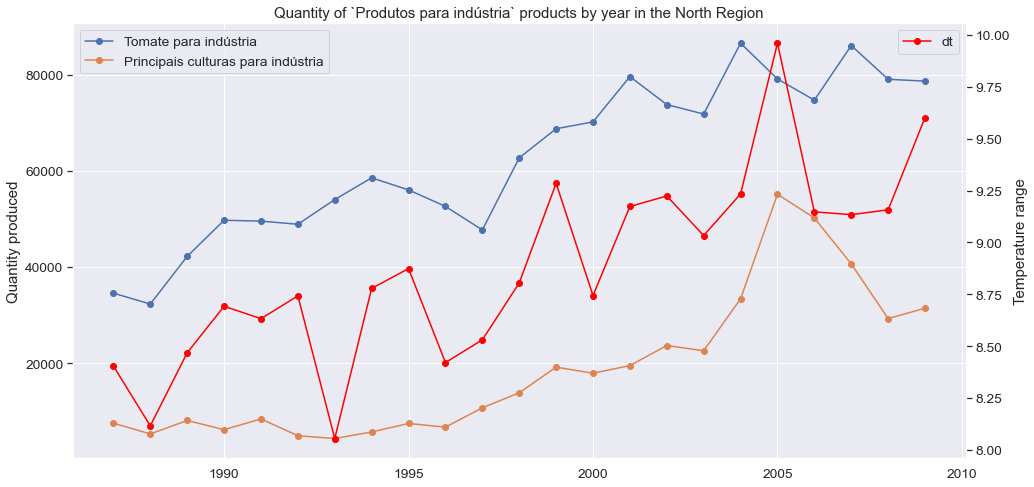

In [125]:
plt.figure(figsize=(16, 8))
region_code = 18
max_year = 2010
meteo_region = meteo.xs(region_code)
data_region = data.xs(str(region_code))
products = ["Tomate para indústria", "Principais culturas para indústria"]
index_min = list(meteo_region.index).index(1987)
index_max = list(meteo_region.index).index(max_year)
meteo_region = meteo_region.iloc[range(index_min,index_max)]

index_min = list(data_region.index).index("1987")
index_max = list(data_region.index).index(str(max_year))
data_region = data_region[products].iloc[range(index_min,index_max)]

year = range(1987, max_year)
plt.plot(year, data_region.values, label=products, marker="o")
year = range(1987, max_year)
plt.ylabel("Quantity produced")
plt.legend()
ax2 = plt.twinx()
ax2.plot(year, meteo_region["dT"], color="red", marker="o", label="dt")
plt.ylabel("Temperature range")
plt.grid()
plt.title("Quantity of `Produtos para indústria` products by year in the North Region")
plt.xlabel("Years")
products.append("dT")
plt.legend()
plt.xticks(rotation="vertical")
plt.show()

## Regplot
To explore how one variable in the meteorologic boletin affects one production in linear terms

In [126]:
def meteo_data_region(region_code=11, min_year=1997, max_year=2010, products=None, delta=0):
    if products is None:
        products = ["Trigo"]
    meteo_region = meteo.xs(region_code)
    data_region = data.xs(str(region_code))
    index_min = list(meteo_region.index).index(min_year)
    index_max = list(meteo_region.index).index(max_year)
    meteo_region = meteo_region.iloc[range(index_min,index_max)]

    index_min = list(data_region.index).index(str(min_year))
    index_max = list(data_region.index).index(str(max_year))
    data_region = data_region[products].iloc[range(index_min+delta,index_max+delta)]
    year = range(1987, max_year)
    return year, data_region, meteo_region

In [127]:
def reg_plot_products(meteo_x="dT", products="Ameixa", max_year=2016, region=18, min_year=1988):
     year, data_region, meteo_region = meteo_data_region(region_code=region, min_year=min_year, max_year=max_year, products=[products])
     data_region.index = data_region.index.map(str)
     meteo_region.index = meteo_region.index.map(str)
     df = meteo_region.join(data_region)
     cm = np.corrcoef(df[meteo_x], df[products])
     print(f"They have a correlation of {cm[0, 1]*100:.2f}")
     plt.figure(figsize=(16, 8))
     sns.regplot(data=df, x=meteo_x, y=products)
     for line in range(df.shape[0]):
          plt.text(df[meteo_x][line], df[products][line], df.index[line], horizontalalignment='left', size=10, color='black', weight='semibold')

They have a correlation of 81.84


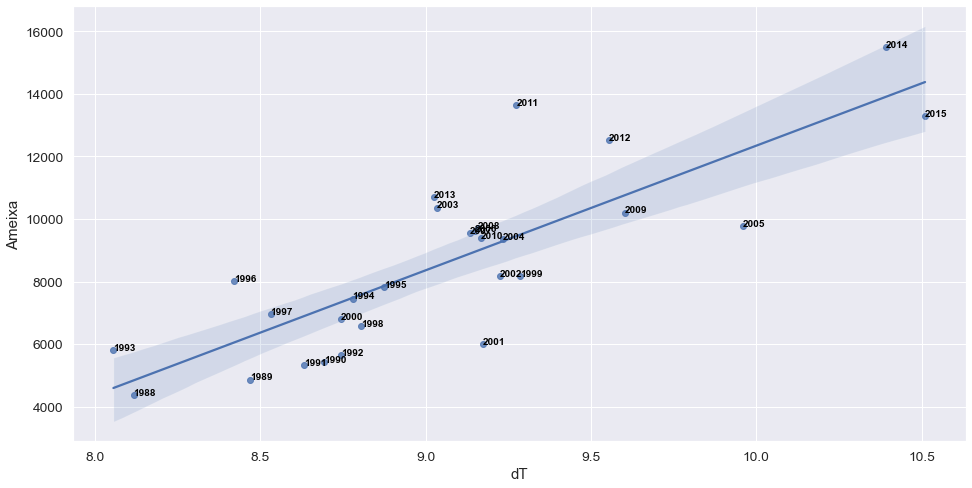

In [128]:
reg_plot_products()

They have a correlation of -47.12


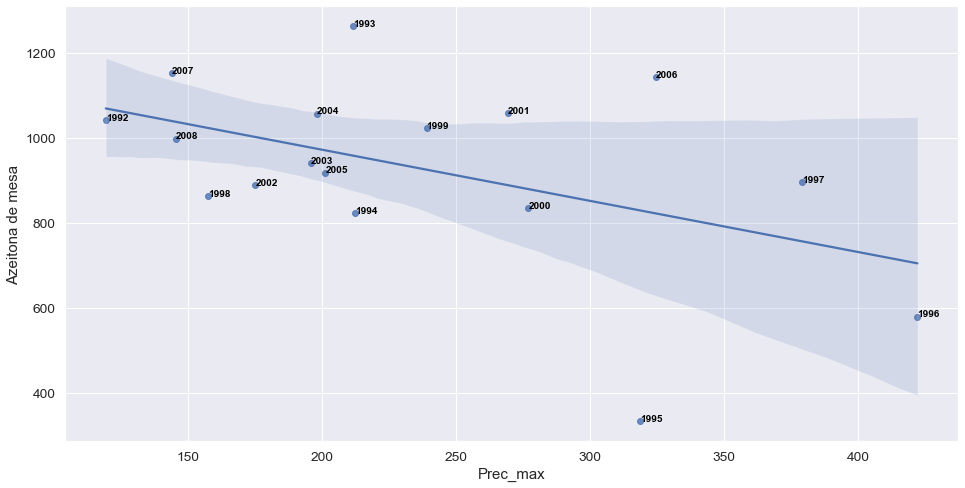

In [129]:
reg_plot_products(meteo_x="Prec_max", products="Azeitona de mesa", max_year=2009, region=18, min_year=1992)

They have a correlation of 84.16


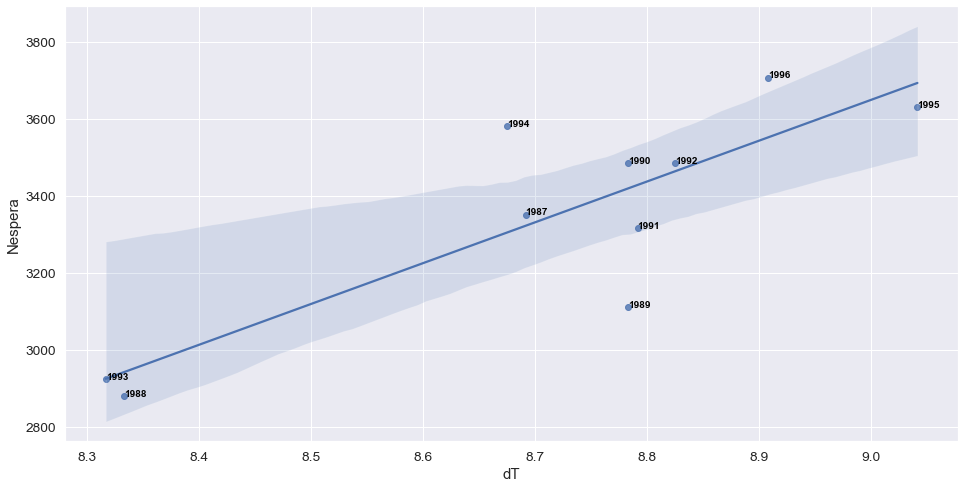

In [130]:
reg_plot_products(meteo_x="dT", products="Nespera", max_year=1997, region=11, min_year=1987)

They have a correlation of 79.98


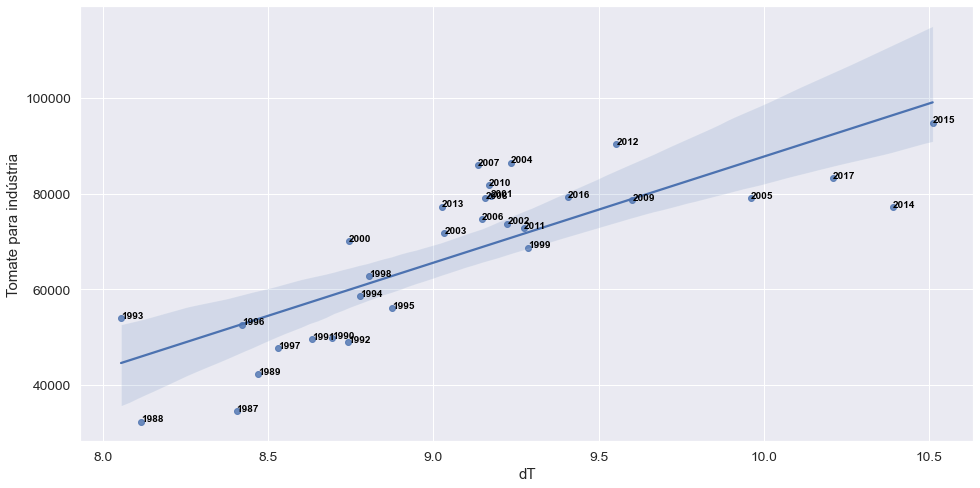

In [131]:
reg_plot_products(meteo_x="dT", products="Tomate para indústria", max_year=2018, region=18, min_year=1987)

## PCA for meteo data
Trying to study similarities between the years in terms of their metereological data

In [132]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca1=PCA(n_components=2)

In [133]:
meteo_scaled=StandardScaler().fit_transform(meteo_region)
principalComponents = pca1.fit_transform(meteo_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [134]:
meteo_pca = pca1.transform(meteo_scaled)

In [135]:
pca1.explained_variance_ratio_

array([0.35397114, 0.23785395])

Our PCA only covers around 60% of the variance of the data which is not very good. Still, it may be interesting to try to visualize some similarities using these two principal components (with 3 principal components the PCA covers ~77%).

(Before adding the dT and dTA intervals to the meto data the PCA would cover 74% with 2 components and 86% with 3. The results obtained were similar).

In [136]:
print(meteo_region.columns)
print(pca1.components_)

Index(['Prec', 'Prec_max', 'Prec_min', 'Tmax', 'TmaxA', 'Tmin', 'TminA', 'dT',
       'dTA'],
      dtype='object')
[[-0.27439507 -0.10011796 -0.10397897  0.42592327  0.47074025  0.19671893
  -0.25343853  0.40988435  0.47951069]
 [ 0.55117651  0.61669025  0.24584888  0.24991477 -0.0038911   0.39911859
  -0.15427619 -0.05617024  0.08204567]]


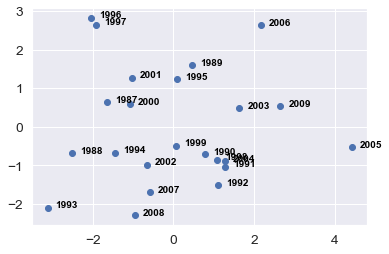

In [137]:
# Plotting the results
labels=meteo_region.index
plt.scatter(meteo_pca[:,0], meteo_pca[:,1], label=labels)
for line, label in enumerate(labels):
     plt.text(meteo_pca[:,0][line]+0.2, meteo_pca[:,1][line], label, horizontalalignment='left', size=10, color='black', weight='semibold')

One of the things we can observe in the figure above is that the meteorological data of a certain year can be very different from the previous year.

## Boxplot of productions by region

In [138]:
def boxplot_data():
    data_regions = data.reset_index()
    return data_regions.set_index("Year")

<AxesSubplot:xlabel='Region', ylabel='Milho'>

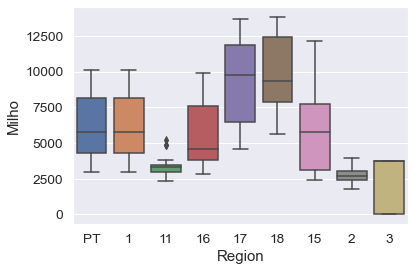

In [139]:
data_regions = boxplot_data()
sns.boxplot(data=data_regions, x="Region", y="Milho")

<AxesSubplot:xlabel='Region', ylabel='Tomate para indústria'>

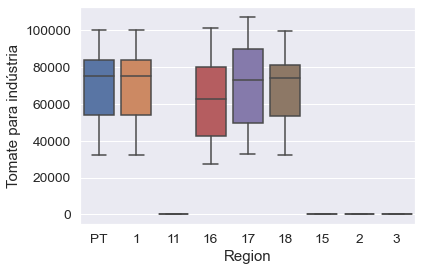

In [140]:
sns.boxplot(data=data_regions, x="Region", y="Tomate para indústria")

## What was the evolution of products
The main question was eher to compare how the products production evolved overtime using the 2000 as a baseline, and review the dataset for every 5 years thereafter.

In [141]:
baseline_year = 2000

def evolution_baseline(region, baseline_year):
    def product_base_comp(region, year_study):
        data_region = data.xs(str(region))
        year_index = list(data_region.index).index(str(year_study))
        return data_region.iloc[year_index]

    d1 = pd.DataFrame()
    for year in [2000, 2005, 2010, 2015, 2020]:
        d1[year] = product_base_comp(region, year)

    d1["temp"] = d1[baseline_year]
    for year in [2000, 2005, 2010, 2015, 2020]:
        d1[year] /= d1["temp"]

    d1.dropna(axis = 0, how = 'all', inplace = True)
    d1.drop("temp", axis=1, inplace=True)
    return d1

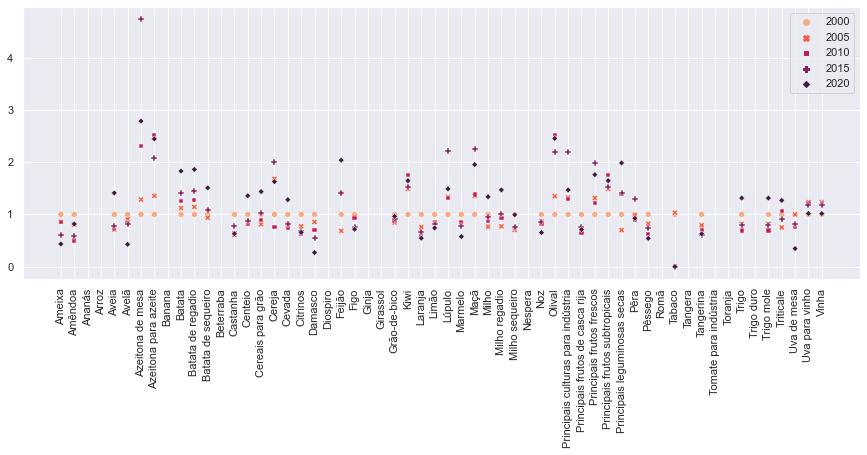

In [142]:
d1 = evolution_baseline(11, baseline_year)
sns.set(rc = {'figure.figsize':(15,5)})
sns.scatterplot(data=d1, palette='rocket_r')
plt.rcParams["xtick.labelsize"] = 10
plt.xticks(rotation=90)
plt.show()

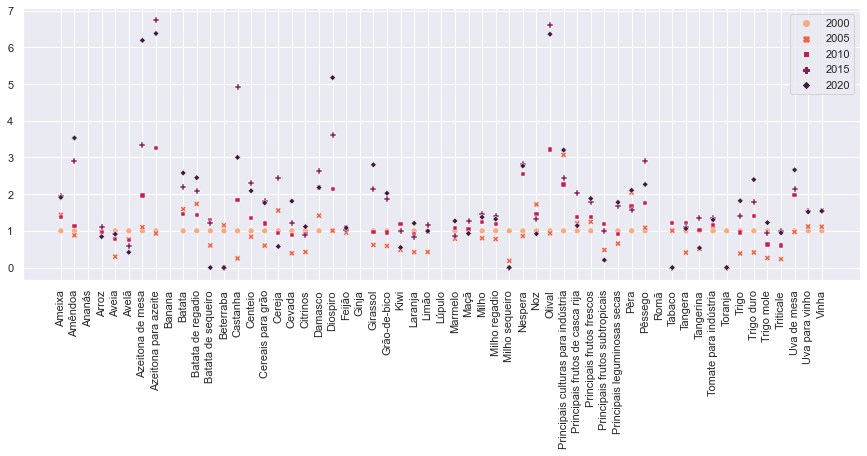

In [143]:
d2 = evolution_baseline(18, baseline_year)
sns.set(rc = {'figure.figsize':(15,5)})
d2.drop('Figo', axis=0, inplace=True)
sns.scatterplot(data=d2, palette='rocket_r')
plt.rcParams["xtick.labelsize"] = 10
plt.xticks(rotation=90)
plt.show()

On the 2 graphs above we can see how the production changed from the 2000 to 2005, 2010, 2015, 2020.
On the second graph (region 18) we decided to remove the Figo, since it made a giant leap in production (20x), making it harder to see all the other products evolution.

By comparing the 2 graphs, the region 18 seems to evolve more leading a better production overall, while the region 11 seems to have decrease the production.